## Clustering with K-Means

In [13]:
from sklearn import datasets
import matplotlib.pyplot as plt

In [14]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=[0.5, 0.5, 0.5, 1, 1])

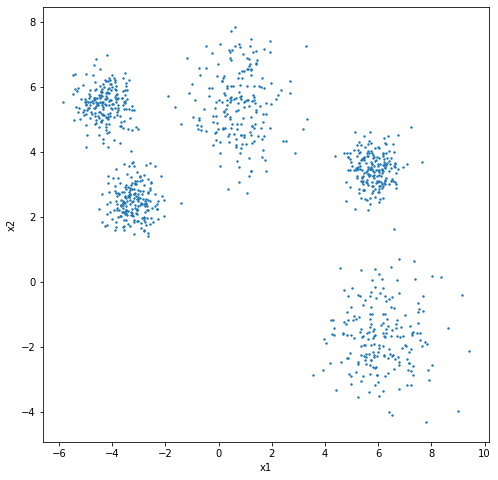

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [16]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [17]:
y_pred is kmeans.labels_

True

In [18]:
# 5 centroids found
kmeans.cluster_centers_

array([[-4.28296232,  5.48594878],
       [ 6.1046461 , -1.71735221],
       [ 0.75440027,  5.44265101],
       [-3.21956111,  2.47950252],
       [ 5.8066705 ,  3.46294345]])

In [19]:
import numpy as np
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

In [20]:
kmeans.predict(X_new)

array([3, 4, 3, 3])

In [21]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [22]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

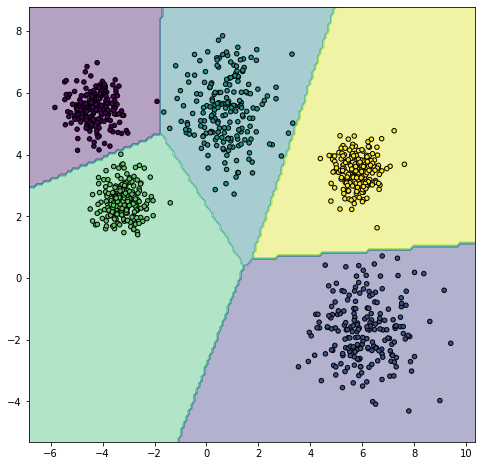

In [23]:
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, edgecolor='k')
plt.show()

In [24]:
# distance from each instance to every centroid
kmeans.transform(X_new)

array([[ 5.5222826 ,  7.14740592,  3.52433905,  3.25507241,  5.98812373],
       [ 8.0742417 ,  4.84329793,  4.11029976,  6.23801755,  3.16505969],
       [ 2.79748702, 10.25416951,  4.4790697 ,  0.56491124,  8.81882996],
       [ 3.24990499, 10.0339743 ,  4.77019039,  0.22051582,  8.8591594 ]])

In [25]:
# when you know where the centroids are
good_init = np.array([[-3,3], [-3,2], [-3,1], [-1,2], [0,2]])
kmeans = KMeans(n_clusters=5, init = good_init, n_init=1)

#### Accelerated K-Means anda Mini-Batch K-Means

In [27]:
from sklearn.cluster import MiniBatchKMeans

In [29]:
minibatch_kmeans = MiniBatchKMeans(n_clusters = 5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [36]:
#performance measure
from sklearn.metrics import silhouette_score
silhouette_score(X, minibatch_kmeans.labels_)

0.696722952141118

In [37]:
scores = list()
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    scores.append(silhouette_score(X, kmeans.labels_))
    del(kmeans)

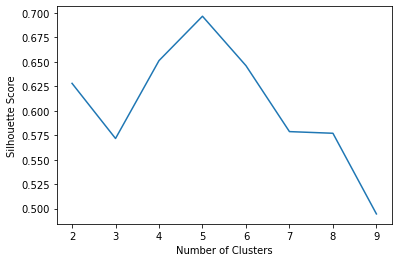

In [38]:
plt.plot(list(range(2, 10)), scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show() #five cluster is the best choice

### Using Clustering for Image Segmentation

In [41]:
from matplotlib.image import imread
import os

In [46]:
image = imread(os.path.join("images", "unsupervised_learning", "ladybug.png"))

In [47]:
image.shape

(533, 800, 3)

In [50]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [51]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


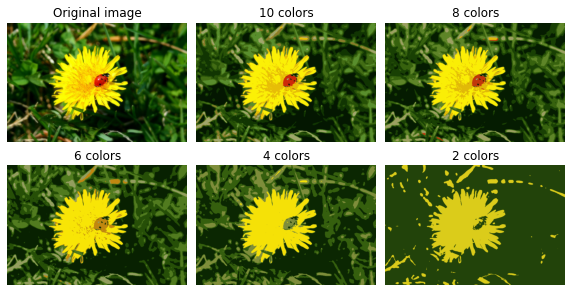

In [52]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### Clustering for Preprocessing
- dimensionality reduction

In [53]:
from sklearn.datasets import load_digits

In [54]:
X_digits, y_digits = load_digits(return_X_y= True)

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [57]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')
log_reg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [58]:
log_reg.score(X_test, y_test)

0.9644444444444444

In [81]:
# adding a preprocessing step(clustering)
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression(solver='liblinear', multi_class='auto'))
])

In [82]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg', LogisticRegression(solver='liblinear'))])

In [83]:
pipeline.score(X_test, y_test)

0.9711111111111111

We can use GridSearchCV to find the optimal number of clusters based on the final scoring by Logistic Regression

In [72]:
from sklearn.model_selection import GridSearchCV

In [84]:
param_dict = dict(kmeans__n_clusters=range(50,125))

In [85]:
grid_clf = GridSearchCV(pipeline, param_dict, cv=3, verbose=2)

In [86]:
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END ..............................kmeans__n_clusters=50; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=50; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=50; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=51; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=51; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=51; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=52; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=52; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=52; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=53; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=53; total time=   0.4s
[CV] END ..............................kmeans__

[CV] END ..............................kmeans__n_clusters=83; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=84; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=84; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=84; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=85; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=85; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=85; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=86; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=86; total time=   0.8s
[CV] END ..............................kmeans__n_clusters=86; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=87; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=87; total time=   0.7s
[CV] END ...................

[CV] END .............................kmeans__n_clusters=117; total time=   1.0s
[CV] END .............................kmeans__n_clusters=118; total time=   1.0s
[CV] END .............................kmeans__n_clusters=118; total time=   0.9s
[CV] END .............................kmeans__n_clusters=118; total time=   1.0s
[CV] END .............................kmeans__n_clusters=119; total time=   1.0s
[CV] END .............................kmeans__n_clusters=119; total time=   1.0s
[CV] END .............................kmeans__n_clusters=119; total time=   1.0s
[CV] END .............................kmeans__n_clusters=120; total time=   1.1s
[CV] END .............................kmeans__n_clusters=120; total time=   1.2s
[CV] END .............................kmeans__n_clusters=120; total time=   1.0s
[CV] END .............................kmeans__n_clusters=121; total time=   1.0s
[CV] END .............................kmeans__n_clusters=121; total time=   1.0s
[CV] END ...................

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'kmeans__n_clusters': range(50, 125)}, verbose=2)

In [87]:
grid_clf.best_params_

{'kmeans__n_clusters': 94}

In [88]:
grid_clf.score(X_test, y_test)

0.9711111111111111

### Clustering for Semi-Supervised Learning

In [89]:
n_labeled = 50

In [90]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [91]:
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(solver='liblinear')

In [92]:
log_reg.score(X_test, y_test)

0.7822222222222223

In [94]:
# cluster the training setinto 50 cluster (one image per cluster)
k = 50
kmeans = KMeans(n_clusters=k)

X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

In [95]:
#manually labeling the instances 
y_representative_digits = y_train[representative_digit_idx].copy()

In [96]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [97]:
log_reg.fit(X_representative_digits, y_representative_digits)

LogisticRegression(solver='liblinear')

In [98]:
log_reg.score(X_test, y_test)

0.88

Label Propagation

In [99]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)

In [100]:
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [101]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [102]:
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(solver='liblinear')

In [103]:
log_reg.score(X_test, y_test)

0.9155555555555556

 - only propagate the labels to the 20% of the instances that are closest to the centroids

In [104]:
percentile_closest = 20.
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

In [105]:
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [106]:
partially_propagated = (X_cluster_dist != -1)

In [107]:
X_train_partially_propagated = X_train[partially_propagated]

In [108]:
y_train_partially_propagated = y_train[partially_propagated]

In [109]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')

In [110]:
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(solver='liblinear')

In [111]:
log_reg.score(X_test, y_test)

0.9244444444444444